In [2]:
import numpy as np
import tensorflow as tf
import os
import cv2
%matplotlib inline 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import optimizers

In [14]:
# Constants
DATASET_PATH = "dataset"
IMAGE_SIZE = (128,128)
BATCH_SIZE = 32
CLASS_NAMES = ["fire", "nonfire"]
EPOCHS=5

In [15]:
# Load the data
train_gen = ImageDataGenerator(rescale=1./255, 
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
validation_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_images = train_gen.flow_from_directory(
    directory="dataset/training",
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="binary",
    classes=CLASS_NAMES,
    batch_size=BATCH_SIZE,
    color_mode="rgba"
)

validation_images = validation_gen.flow_from_directory(
    directory="dataset/validation",
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="binary",
    classes=CLASS_NAMES,
    batch_size=BATCH_SIZE,
    color_mode="rgba"
)

test_images = test_gen.flow_from_directory(
    directory="dataset/test",
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="binary",
    classes=CLASS_NAMES,
    batch_size=1,
    color_mode="rgba"
)

print(train_images.samples)

Found 1704 images belonging to 2 classes.
Found 440 images belonging to 2 classes.
Found 477 images belonging to 2 classes.
1704


/home/martin/.local/share/virtualenvs/d7041e-mini-project-qo9XQE3w/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


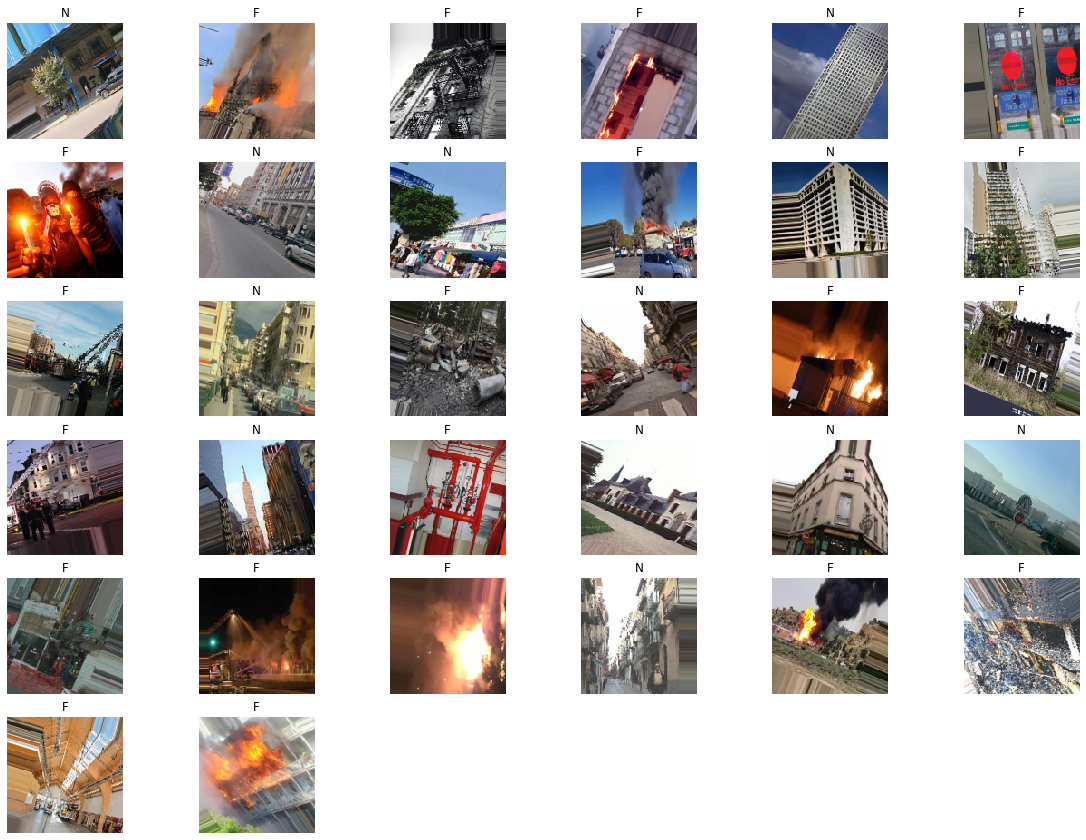

In [16]:
def show_batch(image_batch, label_batch, answers=None):
  plt.figure(figsize=(20,20))
  for n in range(len(image_batch)):
      ax = plt.subplot(8, 6,n+1)
      plt.imshow(image_batch[n])
      plt.title(f'{CLASS_NAMES[label_batch[n]==1][0].title()}{answers[n] if answers is not None else ""}')
      plt.axis('off')
        
# Display the first batch        
image_batch, label_batch = next(train_images)
show_batch(image_batch, label_batch)

In [17]:
print(f'Loaded {BATCH_SIZE * (len(train_images) - 1) + len(train_images[len(train_images) - 1][0])} images')
print(f'Created {len(train_images)} batches')

Loaded 1704 images
Created 54 batches


In [18]:
class CNN:
    def __init__(self):
        self.model = Sequential()
        chanDim = -1
        normalization_axis = -1
        
        #Layer 1
        self.model.add(SeparableConv2D(32, (3, 3), padding="same", activation="relu"))
        self.model.add(BatchNormalization(axis=normalization_axis))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        
        #Layer 2
        self.model.add(SeparableConv2D(64, (3, 3), padding="same", activation="relu"))
        self.model.add(BatchNormalization(axis=normalization_axis))
        self.model.add(SeparableConv2D(64, (3, 3), padding="same", activation="relu"))
        self.model.add(BatchNormalization(axis=normalization_axis))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        
        #Layer 3
        self.model.add(Flatten())
        self.model.add(Dense(128, activation="relu"))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        #Layer 4
        self.model.add(Dense(128, activation="relu"))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        #Layer 5 (output layer)
        self.model.add(Dense(1, activation="sigmoid"))
        
        opt = optimizers.SGD(learning_rate=1e-4)
        
        self.model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

cnn = CNN()

In [7]:
MODEL_SAVE_PATH='128_image_size.h5'

In [8]:
#Load model (uncomment this when training below)
#cnn.model = tf.keras.models.load_model(MODEL_SAVE_PATH)

In [19]:
def train():
    H = cnn.model.fit_generator(
        train_images,
        steps_per_epoch=train_images.samples // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_data = validation_images, 
        validation_steps = validation_images.samples // BATCH_SIZE
    )
    return H
    
H = train()

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 53 steps, validate for 13 steps
Epoch 1/5
53/53 [==============================] - 55s 1s/step - loss: 1.0181 - accuracy: 0.5185 - val_loss: 0.6943 - val_accuracy: 0.4904
Epoch 2/5
53/53 [==============================] - 62s 1s/step - loss: 0.8845 - accuracy: 0.5724 - val_loss: 0.6990 - val_accuracy: 0.4904
Epoch 3/5
53/53 [==============================] - 63s 1s/step - loss: 0.8773 - accuracy: 0.5766 - val_loss: 0.6983 - val_accuracy: 0.4904
Epoch 4/5
53/53 [==============================] - 59s 1s/step - loss: 0.7819 - accuracy: 0.6292 - val_loss: 0.6962 - val_accuracy: 0.4904
Epoch 5/5
53/53 [==============================] - 58s 1s/step - loss: 0.7836 - accuracy: 0.6322 - val_loss: 0.6889 - val_accuracy: 0.4904


In [10]:
# Save model
cnn.model.save('128_image_size.h5')

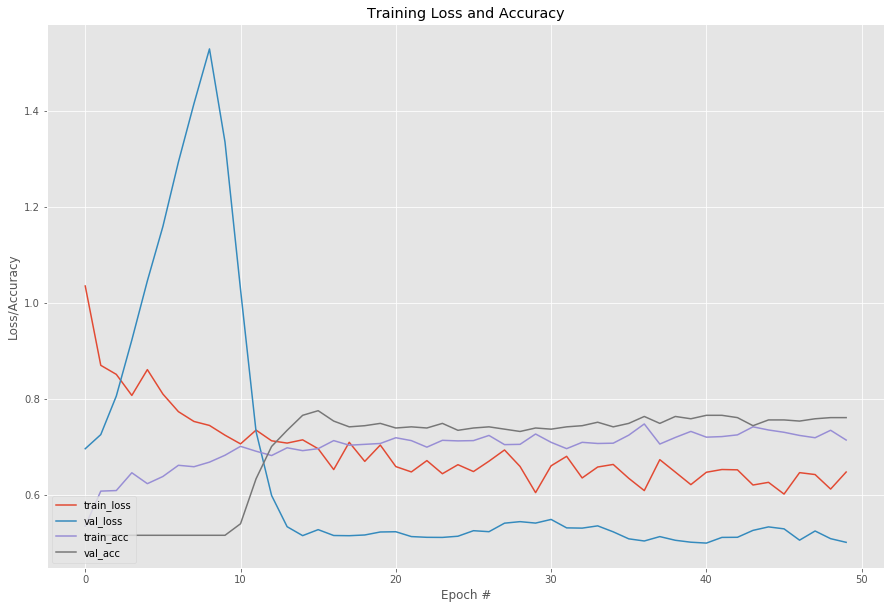

In [11]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(config.TRAINING_PLOT_PATH)

In [12]:
images, labels = next(test_images)

test_result = cnn.model.evaluate(
    test_images,
    verbose=1,
)

# predictions
#answers = np.where(predictions < 0.5, "fire", "nonfire")

#print(answers)
#show_batch(images, labels, answers)
#matches = np.equal(np.array(labels).reshape(len(labels), 1), np.where(predictions < 0.5, 0, 1))
#print(matches)
#print(np.count_nonzero(matches))
#print(f'accuracy {np.count_nonzero(matches) / len(matches)}')
#print(np.where(predictions < 0.5, 1, 0))
#print(np.equal(np.array(labels), np.where(predictions < 0.5, 1, 0)))
#print(f'accuracy: {labels == })

  ...
    to  
  ['...']
477/477 [==============================] - 8s 18ms/step - loss: 0.4754 - accuracy: 0.7841


Found 3 images belonging to 2 classes.
[[0.46834633]
 [0.48914057]
 [0.4558563 ]]


/home/martin/.local/share/virtualenvs/d7041e-mini-project-qo9XQE3w/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


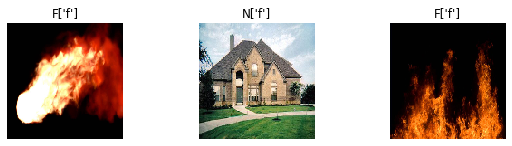

In [26]:
#demo 
demo_gen = ImageDataGenerator(rescale=1./255)

demo_images = demo_gen.flow_from_directory(
    directory="dataset/demo",
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="binary",
    classes=CLASS_NAMES,
    color_mode="rgba"
)

predictions = cnn.model.predict(demo_images)
print(predictions)
answers = np.where(predictions < 0.5, "f", "n")

image_batch, label_batch = next(demo_images)
show_batch(image_batch, label_batch, answers)